# Leitura dos Dados

* Série temporal de preços de Energia CCEE


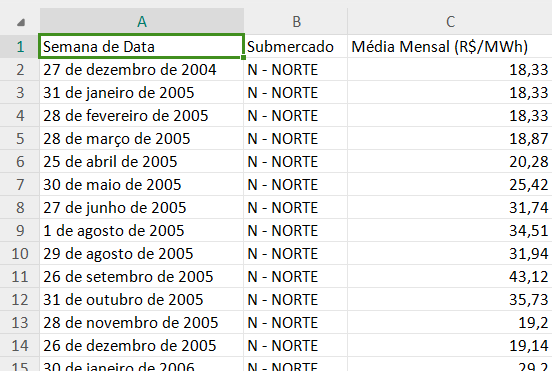

Esta função faz o seguinte:

* Lê o arquivo CSV usando o delimitador correto (;).
* Substitui os meses em português por seus equivalentes em inglês.
* Converte a coluna de datas para o formato datetime.
* Retorna o DataFrame com a coluna de datas corrigida.

In [ ]:
from google.colab import drive
import pandas as pd

# Monta o Google Drive no ambiente
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
def ler_planilha_corrigir_datas(caminho_arquivo):
    """
    Função para ler a planilha e corrigir a coluna de datas para o formato adequado.

    Parâmetros:
    - caminho_arquivo: Caminho do arquivo CSV.

    Retorno:
    - DataFrame pandas com a coluna de datas convertida corretamente.
    """
    # Carregar o arquivo CSV usando o delimitador correto ";"
    df = pd.read_csv(caminho_arquivo, delimiter=';')

    # Dicionário para traduzir os meses de português para inglês
    meses_portugues = {
        'janeiro': 'January', 'fevereiro': 'February', 'março': 'March', 'abril': 'April',
        'maio': 'May', 'junho': 'June', 'julho': 'July', 'agosto': 'August',
        'setembro': 'September', 'outubro': 'October', 'novembro': 'November', 'dezembro': 'December'
    }

    # Substituir os meses em português por seus equivalentes em inglês na coluna de datas
    for mes_pt, mes_en in meses_portugues.items():
        df['Semana de Data'] = df['Semana de Data'].str.replace(mes_pt, mes_en)

    # Converter a coluna de datas para o formato datetime
    df['Semana de Data'] = pd.to_datetime(df['Semana de Data'], format='%d de %B de %Y')

    return df

In [ ]:
# Definir o caminho do arquivo no Google Drive (altere pelo caminho real do seu arquivo)
caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/SoftwareV1/Média Mensal Comercial por Submercado_data.csv'

# Exemplo de uso da função
df_corrigido = ler_planilha_corrigir_datas(caminho_arquivo)

# Exibir as primeiras linhas do DataFrame corrigido
df_corrigido.head()


NameError: name 'ler_planilha_corrigir_datas' is not defined

# Quantidade de Hidrôgenio produzida, Energia Consumida, Degradação do Eletrolisador

**Eletrolisador**

Atributo tipo: O tipo de eletrolisador (Alcalino ou PEM) foi adicionado como parâmetro no construtor da classe. Se o tipo não for especificado, o padrão será "Alcalino".

Verificação de tipo: Caso o tipo de eletrolisador informado não seja "Alcalino" ou "PEM", o código lança uma exceção (ValueError), garantindo que o valor seja válido.

Método tipo_eletrolisador(): Adicionei esse método para retornar o tipo de eletrolisador. Isso será útil em funções futuras, como calcular custos operacionais, já que o tipo de eletrolisador pode influenciar os cálculos.

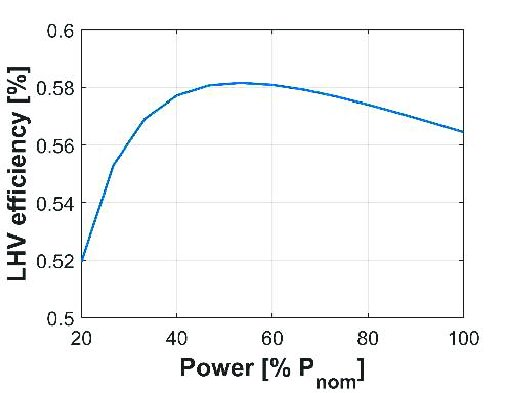

* Curvas de Eficiência em função da Potência de Operação dos diferentes tipos de eletrolisador


https://nelhydrogen.com/product/atmospheric-alkaline-electrolyser-a-series/

In [ ]:
import numpy as np
import plotly.graph_objects as go

#add referencia com o DOI

class Eletrolisador:
    def __init__(self, eficiencia_potencia, tensao_corrente, proporcao_h2_max_eficiencia, agua_hidrogenio, tipo="Alcalino"):
        """
        Inicializa os dados do eletrolisador.

        :param eficiencia_potencia: Lista de pares (potencia, eficiencia) da curva de eficiencia.
        :param tensao_corrente: Lista de pares (corrente, tensão) da relação tensão-corrente.
        :param proporcao_h2_max_eficiencia: Proporção de H2 produzido por kWh no ponto de máxima eficiência (kg/kWh).
        :param agua_hidrogenio: Par ordenado (massa de H2, água consumida no ponto de máxima eficiência).
        :param tipo: Tipo do eletrolisador ("Alcalino" ou "PEM").
        """
        self.eficiencia_potencia = eficiencia_potencia  # [(P1, eta1), (P2, eta2), ...]
        self.tensao_corrente = tensao_corrente          # [(I1, V1), (I2, V2), ...]
        self.proporcao_h2_max_eficiencia = proporcao_h2_max_eficiencia  # kg de H2 por kWh no ponto de máxima eficiência
        self.agua_hidrogenio = agua_hidrogenio          # (massa de H2, água consumida) no ponto de máxima eficiência

        # Verifica se o tipo é válido
        if tipo not in ["Alcalino", "PEM"]:
            raise ValueError("Tipo de eletrolisador inválido. Escolha 'Alcalino' ou 'PEM'.")

        self.tipo = tipo  # Define o tipo do eletrolisador

    def ajustar_para_potencia_nominal(self, potencia_nominal):
        """
        Ajusta os valores de potência da curva de eficiência com base na nova potência nominal.
        Escala os valores de potência da curva para a potência nominal fornecida pelo usuário.
        """
        potencias_originais, eficiencias = zip(*self.eficiencia_potencia)
        fator_ajuste = potencia_nominal / max(potencias_originais)  # Ajuste proporcional
        potencias_ajustadas = [p * fator_ajuste for p in potencias_originais]
        self.eficiencia_potencia = list(zip(potencias_ajustadas, eficiencias))

    def encontrar_ponto_maxima_eficiencia(self):
        """
        Retorna o ponto de potência de máxima eficiência na curva.
        """
        potencias, eficiencias = zip(*self.eficiencia_potencia)
        # Ajusta um polinômio de grau 4 aos dados
        coef = np.polyfit(potencias, eficiencias, 4)
        polinomio = np.poly1d(coef)
        # Gerar pontos suavizados para encontrar o máximo
        potencias_suavizadas = np.linspace(min(potencias), max(potencias), 1000)
        eficiencias_suavizadas = polinomio(potencias_suavizadas)
        indice_max = np.argmax(eficiencias_suavizadas)
        return potencias_suavizadas[indice_max], eficiencias_suavizadas[indice_max]  # Potência e eficiência máxima

    def eficiencia_em_funcao_da_potencia(self, potencia):
        """
        Retorna a eficiência correspondente para uma dada potência usando um polinômio de grau 4.
        """
        potencias, eficiencias = zip(*self.eficiencia_potencia)
        # Ajusta um polinômio de grau 4 aos dados
        coef = np.polyfit(potencias, eficiencias, 4)
        # Avalia o polinômio na potência desejada
        polinomio = np.poly1d(coef)
        return polinomio(potencia)

    def calcular_producao_hidrogenio(self, horas_por_dia, dias_por_semana, percentual_potencia, potencia_nominal):
        """
        Calcula a produção de hidrogênio (kg), energia consumida (kWh), degradação, consumo de água e proporções.
        """
        # Potência nominal está em kW, então convertemos para W (1 kW = 1000 W)
        potencia_nominal_watts = potencia_nominal * 1000

        # Cálculo da energia consumida (kWh)
        energia_consumida = potencia_nominal_watts * (percentual_potencia / 100) * horas_por_dia * dias_por_semana / 1000

        # Interpolar a eficiência com base na potência (potência real em W)
        potencia_operacao = potencia_nominal_watts * (percentual_potencia / 100)
        eficiencia = self.eficiencia_em_funcao_da_potencia(potencia_operacao)

        # Ajustar a produção de hidrogênio com base na eficiência em relação ao ponto de máxima eficiência
        # No ponto de máxima eficiência, a proporção é fixa: self.proporcao_h2_max_eficiencia (kg/kWh)
        proporcao_h2_operacao = self.proporcao_h2_max_eficiencia * (eficiencia / 1.0)

        # Cálculo da produção de hidrogênio (kg)
        quantidade_hidrogenio = proporcao_h2_operacao * energia_consumida

        # Degradação do eletrolisador (simplificada)
        degradacao = 0.001 * horas_por_dia * dias_por_semana

        # Proporção de água consumida por kg de H2 no ponto de máxima eficiência
        massa_h2_max, agua_consumida_max = self.agua_hidrogenio  # Proporção no ponto de máxima eficiência
        proporcao_agua_h2 = agua_consumida_max / massa_h2_max

        # O consumo de água depende diretamente da quantidade de H2 produzido, independentemente da eficiência
        agua_consumida = proporcao_agua_h2 * quantidade_hidrogenio

        # Cálculo da proporção de água consumida por kWh no ponto de operação
        proporcao_agua_por_kwh = agua_consumida / energia_consumida

        # Cálculo da proporção de hidrogênio produzido por kWh
        proporcao_h2_por_kwh = quantidade_hidrogenio / energia_consumida

        return quantidade_hidrogenio, energia_consumida, degradacao, agua_consumida, proporcao_agua_por_kwh, proporcao_h2_por_kwh

    def plotar_curva_eficiencia_e_consumo(self, potencia_operacao):
        """
        Plota a curva de eficiência e consumo de água com base nos dados fornecidos e marca o ponto de operação.
        Ajusta um polinômio de grau 4 para suavizar a curva de eficiência e relaciona o consumo de água.

        :param potencia_operacao: Potência em que o eletrolisador está operando (em W).
        """
        # Extrair dados de potência e eficiência
        potencias, eficiencias = zip(*self.eficiencia_potencia)

        # Ajustar um polinômio de grau 4 para a eficiência
        coef_eficiencia = np.polyfit(potencias, eficiencias, 4)
        polinomio_eficiencia = np.poly1d(coef_eficiencia)

        # Gerar pontos suavizados para a curva de eficiência
        potencias_suavizadas = np.linspace(min(potencias), max(potencias), 100)
        eficiencias_suavizadas = polinomio_eficiencia(potencias_suavizadas)

        # Calcular a eficiência para a potência de operação
        eficiencia_operacao = polinomio_eficiencia(potencia_operacao)

        # Calcular o consumo de água para os mesmos pontos de potência
        massa_h2_max, agua_consumida_max = self.agua_hidrogenio  # Proporção no ponto de máxima eficiência
        proporcao_agua_h2 = agua_consumida_max / massa_h2_max
        consumos_agua_suavizados = proporcao_agua_h2 * eficiencias_suavizadas  # Consumo de água baseado na eficiência

        # Criar o gráfico com Plotly
        fig = go.Figure()

        # Adicionar a curva de eficiência suavizada
        fig.add_trace(go.Scatter(x=potencias_suavizadas, y=eficiencias_suavizadas, mode='lines', name='Eficiência'))

        # Adicionar a curva de consumo de água no eixo Y secundário
        fig.add_trace(go.Scatter(x=potencias_suavizadas, y=consumos_agua_suavizados, mode='lines', name='Consumo de Água',
                                 yaxis='y2'))

        # Adicionar os pontos de eficiência originais
        fig.add_trace(go.Scatter(x=potencias, y=eficiencias, mode='markers', name='Pontos Originais'))

        # Adicionar o ponto de operação
        fig.add_trace(go.Scatter(x=[potencia_operacao], y=[eficiencia_operacao],
                                 mode='markers', name='Ponto de Operação', marker=dict(color='red', size=10)))

        # Configuração do layout para o segundo eixo Y
        fig.update_layout(
            title="Curva de Eficiência e Consumo de Água do Eletrolisador",
            xaxis_title="Potência (W)",
            yaxis=dict(
                title="Eficiência",
                titlefont=dict(color="blue"),
                tickfont=dict(color="blue")
            ),
            yaxis2=dict(
                title="Consumo de Água (kg)",
                titlefont=dict(color="green"),
                tickfont=dict(color="green"),
                overlaying='y',  # Sobrepor ao primeiro eixo Y
                side='right'      # Colocar o eixo Y do lado direito
            ),
            showlegend=True
        )

        # Mostrar o gráfico
        fig.show()

# Função para perguntar ao usuário se ele quer usar os dados padrão ou fornecer os próprios dados
def obter_dados_eletrolisador():
    escolha = input("Você gostaria de usar os dados padrão (s/n)? ").lower()

    if escolha == 's':
        # Dados padrão (potências em W)
        dados_eficiencia = [
            (1000, 0.52),  # Eficiência em 1000 W
            (2000, 0.58),  # Eficiência em 2000 W
            (3000, 0.58),  # Pico de eficiência em 3000 W
            (4000, 0.56),  # Queda gradual após 3000 W
            (5000, 0.55)   # Eficiência em 5000 W
        ]
        dados_tensao = [(100, 1.8), (200, 2.0), (300, 2.2)]
        proporcao_h2_max_eficiencia = 0.05  # Exemplo de 0.05 kg de H2 por kWh no ponto de máxima eficiência
        dados_agua_hidrogenio = (1.0, 9.0)  # Para cada 1kg de H2 produzido, 9kg de água consumidos na eficiência máxima
    else:
        # Coletar os dados do usuário
        dados_eficiencia = []
        dados_tensao = []
        dados_agua_hidrogenio = None

        print("Forneça os dados de eficiência (potência em kW e eficiência correspondente):")
        for _ in range(3):
            potencia = float(input("Potência (kW): ")) * 1000  # Converte kW para W
            eficiencia = float(input("Eficiência (entre 0 e 1): "))
            dados_eficiencia.append((potencia, eficiencia))

        print("\nForneça os dados de tensão (corrente em A e tensão correspondente):")
        for _ in range(3):
            corrente = float(input("Corrente (A): "))
            tensao = float(input("Tensão (V): "))
            dados_tensao.append((corrente, tensao))

        print("\nForneça a proporção de H2 produzido por kWh no ponto de máxima eficiência (kg/kWh):")
        proporcao_h2_max_eficiencia = float(input("Proporção de H2 (kg/kWh): "))

        print("\nForneça os dados de hidrogênio (massa de H2 em kg e água consumida em litros no ponto de máxima eficiência):")
        massa_hidrogenio = float(input("Massa de H2 (kg): "))
        agua_consumida = float(input("Água consumida (litros): "))
        dados_agua_hidrogenio = (massa_hidrogenio, agua_consumida)

    return dados_eficiencia, dados_tensao, proporcao_h2_max_eficiencia, dados_agua_hidrogenio

# Solicitando os dados do usuário
dados_eficiencia, dados_tensao, proporcao_h2_max_eficiencia, dados_agua_hidrogenio = obter_dados_eletrolisador()

# Criar o eletrolisador com os dados fornecidos ou padrão
eletrolisador = Eletrolisador(dados_eficiencia, dados_tensao, proporcao_h2_max_eficiencia, dados_agua_hidrogenio, tipo="PEM")

# Solicitar os parâmetros de operação do usuário
horas_por_dia = float(input("Insira o número de horas de operação por dia: "))
dias_por_semana = int(input("Insira o número de dias de operação por semana: "))
percentual_potencia = float(input("Insira o percentual da potência nominal (%): "))
potencia_nominal = float(input("Insira a potência nominal do eletrolisador (kW): ")) * 1000  # Converte kW para W

# Ajustar os valores de potência da curva de eficiência para a nova potência nominal
eletrolisador.ajustar_para_potencia_nominal(potencia_nominal)

# Usar os valores fornecidos para calcular a produção de hidrogênio
quantidade_hidrogenio, energia_consumida, degradacao, agua_consumida, proporcao_agua_por_kwh, proporcao_h2_por_kwh = eletrolisador.calcular_producao_hidrogenio(
    horas_por_dia=horas_por_dia,
    dias_por_semana=dias_por_semana,
    percentual_potencia=percentual_potencia,
    potencia_nominal=potencia_nominal / 1000  # Converte para kW para o cálculo
)

# Exibir os resultados
print(f"\nQuantidade de H2: {quantidade_hidrogenio:.2f} kg")
print(f"Energia consumida: {energia_consumida:.2f} kWh")
print(f"Degradação: {degradacao:.2f}%")
print(f"Água consumida: {agua_consumida:.2f} kg")
print(f"Proporção de água consumida por kWh: {proporcao_agua_por_kwh:.2f} kg/kWh")
print(f"Proporção de H2 produzido por kWh: {proporcao_h2_por_kwh:.2f} kg/kWh")

# Plotar a curva de eficiência e o consumo de água e marcar o ponto de operação
potencia_operacao = potencia_nominal * (percentual_potencia / 100)
eletrolisador.plotar_curva_eficiencia_e_consumo(potencia_operacao)


Forneça os dados de eficiência (potência em kW e eficiência correspondente):

Forneça os dados de tensão (corrente em A e tensão correspondente):


# CAPEX



O CAPEX em um projeto de hidrogênio inclui uma variedade de despesas, como:

Custo do eletrolisador: Este é o custo inicial de aquisição do equipamento.
Instalação e comissionamento: Inclui os custos de instalação, infraestrutura elétrica e hidráulica, e o processo de comissionamento.
Custos de engenharia: Despesas relacionadas ao projeto de engenharia, como design do sistema, consultoria, etc.
Infraestrutura: Construção civil, infraestrutura de suporte, sistemas de armazenamento de hidrogênio, etc.
Outros custos: Podem incluir licenças, impostos, treinamento de operadores, e outros custos associados ao projeto.

In [ ]:
def calcular_capex_projeto_hidrogenio(
    custo_eletrolisador,             # Custo do eletrolisador (em euros)
    fração_instalacao,               # Fração do custo total para instalação e comissionamento
    fração_engenharia,               # Fração do custo total para engenharia
    fração_infraestrutura,           # Fração do custo total para infraestrutura
    fração_outros                    # Fração do custo total para outros custos (licenças, impostos, etc.)
):
    """
    Função para calcular o CAPEX de um projeto de hidrogênio, com base em várias frações dos componentes de custo.

    Parâmetros:
    - custo_eletrolisador (float): Custo inicial do eletrolisador.
    - fração_instalacao (float): Fração do custo total atribuída à instalação e comissionamento.
    - fração_engenharia (float): Fração do custo total atribuída à engenharia.
    - fração_infraestrutura (float): Fração do custo total atribuída à infraestrutura.
    - fração_outros (float): Fração do custo total atribuída a outros custos (licenças, impostos, etc.).

    Retorno:
    - capex_total (float): O CAPEX total do projeto.
    """

    # Calcular cada componente do CAPEX com base nas frações fornecidas
    custo_instalacao = custo_eletrolisador * fração_instalacao
    custo_engenharia = custo_eletrolisador * fração_engenharia
    custo_infraestrutura = custo_eletrolisador * fração_infraestrutura
    custo_outros = custo_eletrolisador * fração_outros

    # CAPEX total é a soma de todos os componentes
    capex_total = (
        custo_eletrolisador +
        custo_instalacao +
        custo_engenharia +
        custo_infraestrutura +
        custo_outros
    )

    return capex_total


# OpEx

# LCOH

 Memorial de Cálculo para o Custo de Produção de Hidrogênio por Eletrólise em um Eletrolisador Alcalino

 A função a seguir tem o objetivo de calcular o custo de produção mensal de hidrogênio
 por meio de eletrólise em um eletrolisador alcalino, considerando todos os fatores de
 custo (eletricidade, água, CAPEX amortizado e manutenção).

* 1. Produção Mensal de Hidrogênio
 A produção mensal é calculada com base na produção diária e no número de dias de operação por mês:
 Produção mensal (kg/mês) = Produção diária (kg/dia) * Dias de operação por mês (dias/mês)

* 2. Custo de Eletricidade por kg de Hidrogênio
 O custo de eletricidade por kg de hidrogênio é dado pelo consumo específico de energia (kWh/kg) multiplicado pelo custo da eletricidade (€/kWh):
 Custo de eletricidade por kg (€/kg) = Consumo de energia (kWh/kg) * Custo da eletricidade (€/kWh)

* 3. Custo de Água por kg de Hidrogênio
 O custo de água por kg de hidrogênio é calculado pelo consumo de água (litros/kg) multiplicado pelo custo da água (€/litro):
 Custo de água por kg (€/kg) = Consumo de água (litros/kg) * Custo da água (€/litro)

* 4. Amortização do CAPEX (Custo de Capital)
  O CAPEX total é o investimento inicial no eletrolisador, que é amortizado ao longo do tempo de recuperação do investimento (anos). O número de meses no período de recuperação do investimento é calculado multiplicando o tempo de recuperação por 12:
  Meses de recuperação do investimento = Tempo de recuperação (anos) * 12
      O CAPEX amortizado mensal é então calculado dividindo o CAPEX total pelo     número de meses:
      CAPEX amortizado mensal (€/mês) = CAPEX total (€) / Meses de recuperação do investimento

  O CAPEX amortizado por kg de hidrogênio é obtido dividindo o valor mensal amortizado pela
  produção mensal de hidrogênio:
  CAPEX amortizado por kg (€/kg) = CAPEX amortizado mensal (€/mês) / Produção mensal (kg/mês)

* 5. Custo de Manutenção por kg de Hidrogênio
 O custo de manutenção é calculado como uma fração do CAPEX anual, que é dividido ao longo dos meses:
 Custo de manutenção mensal (€/mês) = (CAPEX * Fração de manutenção anual) / 12

  O custo de manutenção por kg de hidrogênio é calculado dividindo o custo de manutenção mensal pela produção mensal:
  Custo de manutenção por kg (€/kg) = Custo de manutenção mensal (€/mês) / Produção mensal (kg/mês)

* 6. Custo Total de Produção por kg de Hidrogênio
 O custo total por kg de hidrogênio é a soma dos custos de eletricidade, água, CAPEX amortizado e manutenção por kg de hidrogênio produzido:
 Custo total por kg (€/kg) = Custo de eletricidade por kg + Custo de água por kg + CAPEX amortizado por kg + Custo de manutenção por kg

Objetivo: Calcular o custo total de produção mensal por kg de hidrogênio, incluindo CAPEX amortizado e OPEX, sem considerar uma taxa de desconto.
Escopo: Baseia-se em um cálculo direto do CAPEX e do OPEX para um determinado mês, sem ajustar o valor do dinheiro ao longo do tempo.

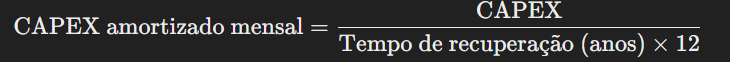

O OPEX mensal é calculado diretamente, sem considerar qualquer ajuste para o valor do dinheiro no tempo.
O OPEX total mensal é a soma dos custos de eletricidade, água e manutenção:

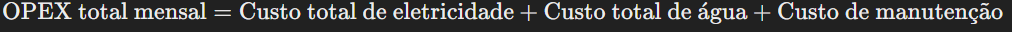

In [ ]:
def calcular_custo_total_producao_mensal(
    consumo_energia,              # kWh/kg
    custo_energia,                # €/kWh
    custo_agua,                   # €/litro
    consumo_agua,                 # litros/kg
    capex,                        # € (custo total do eletrolisador)
    tempo_recuperacao_investimento, # anos (tempo para recuperar o investimento)
    producao_mensal,              # kg/mês (quantidade de hidrogênio produzido por mês)
    manutencao_anual              # fração do CAPEX gasto em manutenção por ano
):
    """
    Função para calcular o custo total de produção mensal por kg de hidrogênio,
    incluindo CAPEX amortizado, OPEX e custos de manutenção.

    Parâmetros:
    - consumo_energia (float): Consumo de energia elétrica por kg de H2 produzido (kWh/kg).
    - custo_energia (float): Preço da eletricidade (€/kWh).
    - custo_agua (float): Preço da água (€/litro).
    - consumo_agua (float): Consumo de água por kg de H2 produzido (litros/kg).
    - capex (float): Custo total do CAPEX (em euros).
    - tempo_recuperacao_investimento (int): Número de anos para recuperar o investimento.
    - producao_mensal (float): Quantidade de hidrogênio produzido no mês (kg/mês).
    - manutencao_anual (float): Fração do CAPEX gasto em manutenção anual (ex.: 0.02 para 2% do CAPEX).

    Retorno:
    - OPEX total (em euros).
    - CAPEX amortizado total (em euros).
    - Custo total por kg de H2 (incluindo CAPEX e OPEX).
    """

    ### Cálculos de OPEX (Custo Operacional) ###

    # Cálculo do custo de eletricidade por kg de hidrogênio produzido
    custo_eletricidade_por_kg = consumo_energia * custo_energia

    # Cálculo do custo de eletricidade total para o mês
    custo_total_eletricidade = custo_eletricidade_por_kg * producao_mensal

    # Cálculo do custo de água por kg de hidrogênio produzido
    custo_agua_por_kg = consumo_agua * custo_agua

    # Cálculo do custo de água total para o mês
    custo_total_agua = custo_agua_por_kg * producao_mensal

    # Cálculo do custo de manutenção mensal (distribuído mensalmente a partir do custo anual)
    custo_manutencao_mensal = (capex * manutencao_anual) / 12

    # OPEX total (somando eletricidade, água e manutenção)
    opex_total_mensal = custo_total_eletricidade + custo_total_agua + custo_manutencao_mensal

    ### Cálculo do CAPEX Amortizado ###

    # Cálculo do número de meses no período de recuperação do investimento
    meses_recuperacao_investimento = tempo_recuperacao_investimento * 12

    # Cálculo do CAPEX amortizado mensal
    capex_amortizado_mensal = capex / meses_recuperacao_investimento

    # Cálculo do CAPEX amortizado por kg de hidrogênio, com base na produção mensal
    capex_amortizado_por_kg = capex_amortizado_mensal / producao_mensal

    ### Cálculo do Custo Total por kg de Hidrogênio ###

    # Cálculo do OPEX por kg de hidrogênio
    opex_por_kg = opex_total_mensal / producao_mensal

    # Cálculo do custo total por kg de hidrogênio (CAPEX amortizado + OPEX)
    custo_total_por_kg = opex_por_kg + capex_amortizado_por_kg

    # Retornar o OPEX total, o CAPEX amortizado e o custo total por kg de H2
    return opex_total_mensal, capex_amortizado_mensal, custo_total_por_kg


Objetivo: Calcular o LCOH anual detalhado usando a depreciação do CAPEX, OPEX, e a produção de hidrogênio, levando em consideração uma taxa de desconto.
Escopo: Leva em consideração o valor do dinheiro no tempo, ajustando o CAPEX e o OPEX ao longo dos anos com uma taxa de desconto.
O CAPEX é depreciado ao longo da vida útil do projeto, levando em consideração a taxa de desconto.
A fórmula para depreciar o CAPEX é:


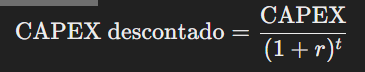

O OPEX anual é ajustado pela taxa de desconto para cada ano, de modo que os custos operacionais futuros têm menos impacto financeiro no presente.
O OPEX para cada ano
𝑡 é calculado como:

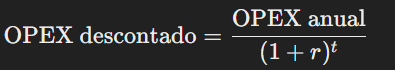

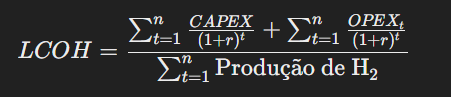

In [ ]:
def calcular_lcoh_anual_detalhado(capex, opex_anual, producao_anual_h2, vida_util, taxa_desconto):
    """z
    Função para calcular o LCOH (Levelized Cost of Hydrogen) de forma detalhada,
    considerando a depreciação do CAPEX e OPEX ao longo do tempo, com ajuste para valor presente.

    Parâmetros:
    - capex (float): Custo total do investimento (CAPEX) em euros.
    - opex_anual (float): Custo operacional anual (OPEX) em euros (assumido constante para simplificação).
    - producao_anual_h2 (float): Quantidade de hidrogênio produzida por ano (em kg).
    - vida_util (int): Vida útil do projeto (em anos).
    - taxa_desconto (float): Taxa de desconto anual (como fração, por exemplo, 0.05 para 5%).

    Retorno:
    - LCOH (float): Custo nivelado de hidrogênio (€/kg) em base anual.
    """

    # Inicializando variáveis para os somatórios
    soma_capex = 0
    soma_opex = 0
    producao_total_h2 = 0

    # Loop para calcular o somatório ao longo da vida útil do projeto
    for t in range(1, vida_util + 1):
        # CAPEX descontado (descontado ao longo do tempo)
        capex_descontado = capex / ((1 + taxa_desconto) ** t)
        soma_capex += capex_descontado

        # OPEX descontado
        opex_descontado = opex_anual / ((1 + taxa_desconto) ** t)
        soma_opex += opex_descontado

        # A produção de hidrogênio não é descontada
        producao_total_h2 += producao_anual_h2

    # Cálculo do LCOH
    lcoh = (soma_capex + soma_opex) / producao_total_h2

    return lcoh

# Exemplo de uso da função
capex = 1000000  # 1.000.000 € de CAPEX
opex_anual = 50000  # 50.000 € de OPEX anual
producao_anual_h2 = 100000  # 100.000 kg de hidrogênio produzido por ano
vida_util = 20  # 20 anos de vida útil do projeto
taxa_desconto = 0.05  # 5% de taxa de desconto

lcoh_anual = calcular_lcoh_anual_detalhado(capex, opex_anual, producao_anual_h2, vida_util, taxa_desconto)
print(f"LCOH anual detalhado: {lcoh_anual:.2f} €/kg")


LCOH anual detalhado: 6.54 €/kg


# NPV

# Análise de Sensibilidade

Variáveis de entrada:

Custo do stack do eletrólito.
Custo dos BOPs (Balance of Plant).
Custo de mão de obra.
Custo da eletricidade.
Custo de manutenção.
Fator de capacidade (percentual de tempo de operação da planta).
Taxa de imposto.
Variações:

Cada variável será ajustada em ±20% em relação ao seu valor de referência.
Monitoramento do LCOH:

Para cada variação de uma variável, o LCOH será recalculado e o impacto será registrado.
Resultado:

A função deve retornar o LCOH para o cenário de referência, além de mostrar os valores do LCOH com +20% e -20% de variação para cada variável.

In [ ]:
def analise_sensibilidade_lcoh(capex, opex_anual, producao_anual_h2, vida_util, taxa_desconto, variaveis):
    """
    Função para realizar a análise de sensibilidade sobre o LCOH, variando diferentes
    parâmetros de entrada (±20%) e monitorando o impacto no LCOH.

    Parâmetros:
    - capex (float): Custo total do investimento (CAPEX) em euros.
    - opex_anual (float): Custo operacional anual (OPEX) em euros.
    - producao_anual_h2 (float): Quantidade de hidrogênio produzida por ano (em kg).
    - vida_util (int): Vida útil do projeto (em anos).
    - taxa_desconto (float): Taxa de desconto anual.
    - variaveis (dict): Dicionário com as variáveis de entrada e seus valores de referência.

    Retorno:
    - dicionário com o LCOH de referência e o LCOH com ±20% de variação para cada variável.
    """
    # Guardar os resultados de LCOH para cada cenário
    resultados = {}

    # Cálculo do LCOH de referência
    lcoh_ref = calcular_lcoh_anual_detalhado(capex, opex_anual, producao_anual_h2, vida_util, taxa_desconto)
    resultados['LCOH_Referencia'] = lcoh_ref

    # Iterar sobre as variáveis de sensibilidade
    for variavel, valor in variaveis.items():
        # Variação de +20%
        if variavel == 'capex':
            lcoh_plus_20 = calcular_lcoh_anual_detalhado(valor * 1.2, opex_anual, producao_anual_h2, vida_util, taxa_desconto)
            lcoh_minus_20 = calcular_lcoh_anual_detalhado(valor * 0.8, opex_anual, producao_anual_h2, vida_util, taxa_desconto)
        elif variavel == 'opex_anual':
            lcoh_plus_20 = calcular_lcoh_anual_detalhado(capex, valor * 1.2, producao_anual_h2, vida_util, taxa_desconto)
            lcoh_minus_20 = calcular_lcoh_anual_detalhado(capex, valor * 0.8, producao_anual_h2, vida_util, taxa_desconto)
        elif variavel == 'producao_anual_h2':
            lcoh_plus_20 = calcular_lcoh_anual_detalhado(capex, opex_anual, valor * 1.2, vida_util, taxa_desconto)
            lcoh_minus_20 = calcular_lcoh_anual_detalhado(capex, opex_anual, valor * 0.8, vida_util, taxa_desconto)

        # Armazenar os resultados para +20% e -20%
        resultados[f'{variavel}_+20'] = lcoh_plus_20
        resultados[f'{variavel}_-20'] = lcoh_minus_20

    return resultados

# Definir as variáveis de entrada de referência
variaveis_referencia = {
    'capex': 1000000,              # 1.000.000 €
    'opex_anual': 50000,           # 50.000 € de OPEX anual
    'producao_anual_h2': 100000    # 100.000 kg de H2 por ano
}

# Executar a análise de sensibilidade
resultados_sensibilidade = analise_sensibilidade_lcoh(
    capex=variaveis_referencia['capex'],
    opex_anual=variaveis_referencia['opex_anual'],
    producao_anual_h2=variaveis_referencia['producao_anual_h2'],
    vida_util=20,                   # 20 anos de vida útil
    taxa_desconto=0.05,             # 5% de taxa de desconto
    variaveis=variaveis_referencia
)

# Exibir os resultados da análise de sensibilidade
for variavel, lcoh in resultados_sensibilidade.items():
    print(f'{variavel}: {lcoh:.2f} €/kg')


LCOH_Referencia: 6.54 €/kg
capex_+20: 7.79 €/kg
capex_-20: 5.30 €/kg
opex_anual_+20: 6.60 €/kg
opex_anual_-20: 6.48 €/kg
producao_anual_h2_+20: 5.45 €/kg
producao_anual_h2_-20: 8.18 €/kg


# Simulação de Monte Carlo

# Payback

# Mínimo *via* Enxame de Partículas

# Teste das Funções